In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[2:]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
del cm_target[6]
del cm_target[5]
del cm_target[4]
del cm_target[3]
del cm_target[2]
del cm_target[1]
del cm_target[0]

In [11]:
cm_target

['case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (45000, 2)
Dimension - heights of Gurney flaps:  (45000, 1)
Dimension - inclination(beta):  (45000, 1)
Dimension - x:  (45000, 3)
Dimension - y:  (45000, 1)


In [21]:
x[:,0] -= 10
x[:,0] /= 5

In [22]:
x[:,0]

array([0.000e+00, 2.000e-04, 4.000e-04, ..., 9.994e-01, 9.996e-01,
       9.998e-01])

In [23]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221229\\9beta"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
#ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

#ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.1,
                                          min_delta = 1e-5, min_lr=1e-05, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
31/31 [==============================] - 2s 13ms/step - loss: 0.1089 - rmse: 0.3298 - val_loss: 0.0655 - val_rmse: 0.2557 - lr: 1.0000e-04
Epoch 2/10000
31/31 [==============================] - 0s 6ms/step - loss: 0.0624 - rmse: 0.2496 - val_loss: 0.0607 - val_rmse: 0.2462 - lr: 1.0000e-04
Epoch 3/10000
31/31 [==============================] - 0s 6ms/step - loss: 0.0605 - rmse: 0.2458 - val_loss: 0.0601 - val_rmse: 0.2450 - lr: 1.0000e-04
Epoch 4/10000
31/31 [==============================] - 0s 6ms/step - loss: 0.0602 - rmse: 0.2451 - val_loss: 0.0599 - val_rmse: 0.2445 - lr: 1.0000e-04
Epoch 5/10000
31/31 [==============================] - 0s 6ms/step - loss: 0.0602 - rmse: 0.2451 - val_loss: 0.0597 - val_rmse: 0.2442 - lr: 1.0000e-04
Epoch 6/10000
31/31 [==============================] - 0s 6ms/step - loss: 0.0598 - rmse: 0.2442 - val_loss: 0.0596 - val_rmse: 0.2438 - lr: 1.0000e-04
Epoch 7/10000
31/31 [==============================] - 0s 6ms/step - loss: 0.0597 - rms

31/31 [==============================] - 0s 8ms/step - loss: 0.0443 - rmse: 0.2103 - val_loss: 0.0445 - val_rmse: 0.2108 - lr: 1.0000e-04
Epoch 55/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0437 - rmse: 0.2087 - val_loss: 0.0443 - val_rmse: 0.2103 - lr: 1.0000e-04
Epoch 56/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0436 - rmse: 0.2086 - val_loss: 0.0439 - val_rmse: 0.2093 - lr: 1.0000e-04
Epoch 57/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0442 - rmse: 0.2099 - val_loss: 0.0438 - val_rmse: 0.2090 - lr: 1.0000e-04
Epoch 58/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0433 - rmse: 0.2078 - val_loss: 0.0433 - val_rmse: 0.2078 - lr: 1.0000e-04
Epoch 59/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0430 - rmse: 0.2072 - val_loss: 0.0443 - val_rmse: 0.2103 - lr: 1.0000e-04
Epoch 60/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0427 - rmse: 0.2065

31/31 [==============================] - 0s 10ms/step - loss: 0.0254 - rmse: 0.1589 - val_loss: 0.0250 - val_rmse: 0.1579 - lr: 1.0000e-04
Epoch 108/10000
31/31 [==============================] - 0s 11ms/step - loss: 0.0245 - rmse: 0.1563 - val_loss: 0.0248 - val_rmse: 0.1573 - lr: 1.0000e-04
Epoch 109/10000
31/31 [==============================] - 0s 10ms/step - loss: 0.0244 - rmse: 0.1558 - val_loss: 0.0241 - val_rmse: 0.1548 - lr: 1.0000e-04
Epoch 110/10000
31/31 [==============================] - 0s 9ms/step - loss: 0.0239 - rmse: 0.1543 - val_loss: 0.0243 - val_rmse: 0.1555 - lr: 1.0000e-04
Epoch 111/10000
31/31 [==============================] - 0s 9ms/step - loss: 0.0236 - rmse: 0.1532 - val_loss: 0.0242 - val_rmse: 0.1553 - lr: 1.0000e-04
Epoch 112/10000
31/31 [==============================] - 0s 9ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0230 - val_rmse: 0.1512 - lr: 1.0000e-04
Epoch 113/10000
31/31 [==============================] - 0s 9ms/step - loss: 0.0242 - rms

31/31 [==============================] - 0s 7ms/step - loss: 0.0133 - rmse: 0.1150 - val_loss: 0.0151 - val_rmse: 0.1225 - lr: 1.0000e-04
Epoch 161/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0148 - rmse: 0.1213 - val_loss: 0.0132 - val_rmse: 0.1146 - lr: 1.0000e-04
Epoch 162/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0140 - rmse: 0.1178 - val_loss: 0.0226 - val_rmse: 0.1501 - lr: 1.0000e-04
Epoch 163/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0164 - rmse: 0.1279 - val_loss: 0.0128 - val_rmse: 0.1129 - lr: 1.0000e-04
Epoch 164/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0126 - rmse: 0.1117 - val_loss: 0.0126 - val_rmse: 0.1119 - lr: 1.0000e-04
Epoch 165/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0127 - rmse: 0.1121 - val_loss: 0.0130 - val_rmse: 0.1138 - lr: 1.0000e-04
Epoch 166/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0121 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0083 - val_rmse: 0.0909 - lr: 1.0000e-04
Epoch 214/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0093 - rmse: 0.0962 - val_loss: 0.0095 - val_rmse: 0.0969 - lr: 1.0000e-04
Epoch 215/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0125 - rmse: 0.1116 - val_loss: 0.0088 - val_rmse: 0.0934 - lr: 1.0000e-04
Epoch 216/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0103 - rmse: 0.1010 - val_loss: 0.0133 - val_rmse: 0.1150 - lr: 1.0000e-04
Epoch 217/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0103 - rmse: 0.1013 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 218/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0114 - rmse: 0.1065 - val_loss: 0.0092 - val_rmse: 0.0954 - lr: 1.0000e-04
Epoch 219/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0081 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0070 - rmse: 0.0829 - val_loss: 0.0094 - val_rmse: 0.0967 - lr: 1.0000e-04
Epoch 267/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0090 - rmse: 0.0943 - val_loss: 0.0068 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 268/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0065 - rmse: 0.0802 - val_loss: 0.0069 - val_rmse: 0.0828 - lr: 1.0000e-04
Epoch 269/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0066 - rmse: 0.0804 - val_loss: 0.0074 - val_rmse: 0.0853 - lr: 1.0000e-04
Epoch 270/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0066 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 271/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0775 - val_loss: 0.0062 - val_rmse: 0.0781 - lr: 1.0000e-04
Epoch 272/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0062 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0051 - rmse: 0.0706 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 320/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0052 - rmse: 0.0714 - val_loss: 0.0050 - val_rmse: 0.0701 - lr: 1.0000e-04
Epoch 321/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0052 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 322/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0185 - rmse: 0.1357 - val_loss: 0.0116 - val_rmse: 0.1075 - lr: 1.0000e-04
Epoch 323/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0069 - rmse: 0.0826 - val_loss: 0.0059 - val_rmse: 0.0761 - lr: 1.0000e-04
Epoch 324/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0052 - rmse: 0.0713 - val_loss: 0.0050 - val_rmse: 0.0702 - lr: 1.0000e-04
Epoch 325/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0100 - rmse: 

31/31 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0777 - val_loss: 0.0069 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 373/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0061 - rmse: 0.0777 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 374/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0060 - rmse: 0.0768 - val_loss: 0.0065 - val_rmse: 0.0803 - lr: 1.0000e-04
Epoch 375/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0060 - rmse: 0.0768 - val_loss: 0.0057 - val_rmse: 0.0752 - lr: 1.0000e-04
Epoch 376/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0056 - rmse: 0.0740 - val_loss: 0.0056 - val_rmse: 0.0745 - lr: 1.0000e-04
Epoch 377/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0055 - rmse: 0.0737 - val_loss: 0.0063 - val_rmse: 0.0787 - lr: 1.0000e-04
Epoch 378/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0056 - rmse: 

31/31 [==============================] - 0s 8ms/step - loss: 0.0044 - rmse: 0.0657 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 426/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0070 - val_rmse: 0.0833 - lr: 1.0000e-04
Epoch 427/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0048 - rmse: 0.0683 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 428/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0726 - val_loss: 0.0086 - val_rmse: 0.0925 - lr: 1.0000e-04
Epoch 429/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0059 - val_rmse: 0.0764 - lr: 1.0000e-04
Epoch 430/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0076 - val_rmse: 0.0868 - lr: 1.0000e-04
Epoch 431/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0046 - rmse: 

31/31 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0546 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 479/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-04
Epoch 480/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0605 - val_loss: 0.0059 - val_rmse: 0.0764 - lr: 1.0000e-04
Epoch 481/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 482/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 483/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0049 - rmse: 0.0690 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 484/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0043 - rmse: 

31/31 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0144 - val_rmse: 0.1195 - lr: 1.0000e-04
Epoch 532/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0047 - rmse: 0.0675 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 533/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 534/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 535/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 536/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0035 - rmse: 0.0580 - val_loss: 0.0050 - val_rmse: 0.0697 - lr: 1.0000e-04
Epoch 537/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0033 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 585/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0034 - rmse: 0.0572 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 586/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 587/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0041 - rmse: 0.0630 - val_loss: 0.0057 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 588/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0029 - val_rmse: 0.0526 - lr: 1.0000e-04
Epoch 589/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0040 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 590/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 638/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0032 - rmse: 0.0554 - val_loss: 0.0044 - val_rmse: 0.0658 - lr: 1.0000e-04
Epoch 639/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0020 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 640/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 641/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 642/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0506 - val_loss: 0.0023 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 643/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0049 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 691/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0518 - val_loss: 0.0033 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 692/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0048 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 693/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.0000e-04
Epoch 694/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0422 - val_loss: 0.0017 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 695/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0025 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 696/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 744/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 745/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0023 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 746/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 747/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0020 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 748/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0019 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 749/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 797/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 798/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0026 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 799/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 800/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0015 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 801/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0496 - val_loss: 0.0016 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 802/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 

31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0432 - val_loss: 0.0013 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 850/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0395 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 851/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0036 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 852/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 853/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0410 - val_loss: 0.0056 - val_rmse: 0.0743 - lr: 1.0000e-04
Epoch 854/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0022 - val_rmse: 0.0464 - lr: 1.0000e-04
Epoch 855/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 903/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 904/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0014 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 905/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 906/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 907/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 908/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 

31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 956/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 957/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 958/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 959/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0356 - val_loss: 0.0062 - val_rmse: 0.0779 - lr: 1.0000e-04
Epoch 960/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 961/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 

31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 9.6819e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 1009/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0399 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 1010/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 1011/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0408 - val_loss: 0.0011 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 1012/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 1013/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 1014/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.001

Epoch 1061/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0369 - val_loss: 0.0040 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 1062/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 1063/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 1064/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 1065/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0432 - val_loss: 0.0012 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 1066/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0395 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 1067/10000
31/31 [==============================] - 0s 8ms/step 

31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0394 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 1114/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0341 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 1115/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 1116/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0372 - val_loss: 8.8404e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 1117/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0434 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 1118/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0384 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 1119/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.001

31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 1166/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 9.0309e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 1167/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0023 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 1168/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0015 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 1169/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0301 - val_loss: 8.6234e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 1170/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0013 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 1171/10000
31/31 [==============================] - 0s 7ms/step - loss: 0

31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 7.9713e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 1218/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0498 - val_loss: 0.0017 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 1219/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 1220/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 1221/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 1222/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 7.8346e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 1223/10000
31/31 [==============================] - 0s 7ms/step - loss: 0

31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 7.9498e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 1270/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 1271/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0026 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 1272/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0017 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 1273/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 1274/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 1275/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.001

31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 1322/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 1323/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.1520e-04 - rmse: 0.0286 - val_loss: 6.9480e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 1324/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0358 - val_loss: 8.6853e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 1325/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.7556e-04 - rmse: 0.0296 - val_loss: 7.3018e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 1326/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 6.9939e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1327/10000
31/31 [==============================] - 0s 8m

Epoch 1373/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0340 - val_loss: 7.5357e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 1374/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0051 - val_rmse: 0.0711 - lr: 1.0000e-04
Epoch 1375/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 7.8746e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 1376/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.2601e-04 - rmse: 0.0270 - val_loss: 6.4501e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 1377/10000
31/31 [==============================] - 0s 7ms/step - loss: 8.9396e-04 - rmse: 0.0282 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 1378/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 1.0000e-04
Epoch 1379/10000
31/31 [==========================

Epoch 1425/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 6.4027e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 1426/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 1427/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0383 - val_loss: 8.1558e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 1428/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.8612e-04 - rmse: 0.0280 - val_loss: 6.9453e-04 - val_rmse: 0.0244 - lr: 1.0000e-04
Epoch 1429/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 0.0014 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 1430/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 1431/10000
31/31 [==============================

Epoch 1477/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.3271e-04 - rmse: 0.0289 - val_loss: 7.1897e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 1478/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.8574e-04 - rmse: 0.0280 - val_loss: 0.0019 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 1479/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 1480/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 7.3379e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 1481/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.4841e-04 - rmse: 0.0274 - val_loss: 6.2301e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 1482/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 1483/10000
31/31 [======================

31/31 [==============================] - 0s 8ms/step - loss: 6.0410e-04 - rmse: 0.0224 - val_loss: 0.0013 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 1529/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0021 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 1530/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 9.8418e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 1531/10000
31/31 [==============================] - 0s 8ms/step - loss: 7.6806e-04 - rmse: 0.0258 - val_loss: 5.7549e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 1532/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0024 - val_rmse: 0.0476 - lr: 1.0000e-04
Epoch 1533/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0014 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 1534/10000
31/31 [==============================] - 0s 8ms/step -

Epoch 1580/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0016 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 1581/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.3413e-04 - rmse: 0.0289 - val_loss: 5.3269e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1582/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.3814e-04 - rmse: 0.0232 - val_loss: 7.2346e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 1583/10000
31/31 [==============================] - 0s 9ms/step - loss: 9.6012e-04 - rmse: 0.0293 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 1584/10000
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 5.6525e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1585/10000
31/31 [==============================] - 0s 9ms/step - loss: 6.2594e-04 - rmse: 0.0229 - val_loss: 5.4651e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 1586/10000
31/31 [==============

31/31 [==============================] - 0s 8ms/step - loss: 8.2048e-04 - rmse: 0.0268 - val_loss: 5.1135e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 1632/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.6116e-04 - rmse: 0.0276 - val_loss: 8.7237e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 1633/10000
31/31 [==============================] - 0s 8ms/step - loss: 7.4655e-04 - rmse: 0.0254 - val_loss: 5.3119e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 1634/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.3186e-04 - rmse: 0.0288 - val_loss: 5.1883e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 1635/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.7711e-04 - rmse: 0.0279 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 1636/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 1637/10000
31/31 [===========================

31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 9.4307e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 1683/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0301 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 1684/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - rmse: 0.0386 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 1.0000e-04
Epoch 1685/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.7062e-04 - rmse: 0.0295 - val_loss: 5.4267e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 1686/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 5.9458e-04 - val_rmse: 0.0222 - lr: 1.0000e-04
Epoch 1687/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 7.5698e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 1688/10000
31/31 [==============================] - 0s 8ms/st

31/31 [==============================] - 0s 8ms/step - loss: 6.5586e-04 - rmse: 0.0235 - val_loss: 5.8089e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 1734/10000
31/31 [==============================] - 0s 8ms/step - loss: 7.8231e-04 - rmse: 0.0261 - val_loss: 9.4982e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 1735/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.9676e-04 - rmse: 0.0282 - val_loss: 4.7860e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 1736/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.0849e-04 - rmse: 0.0284 - val_loss: 6.3065e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 1737/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 1738/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.2207e-04 - rmse: 0.0286 - val_loss: 6.1671e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 1739/10000
31/31 [=======================

31/31 [==============================] - 0s 8ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 6.0639e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 1785/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.0216e-04 - rmse: 0.0264 - val_loss: 5.1837e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 1786/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.2119e-04 - rmse: 0.0228 - val_loss: 5.1815e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 1787/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.4213e-04 - rmse: 0.0272 - val_loss: 7.0688e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 1788/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0328 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 1789/10000
31/31 [==============================] - 0s 8ms/step - loss: 9.5330e-04 - rmse: 0.0292 - val_loss: 7.5383e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 1790/10000
31/31 [===========================

31/31 [==============================] - 0s 8ms/step - loss: 8.2242e-04 - rmse: 0.0268 - val_loss: 4.5773e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 1836/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.7335e-04 - rmse: 0.0239 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 1837/10000
31/31 [==============================] - 0s 8ms/step - loss: 8.1048e-04 - rmse: 0.0266 - val_loss: 4.4603e-04 - val_rmse: 0.0185 - lr: 1.0000e-04
Epoch 1838/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.1560e-04 - rmse: 0.0226 - val_loss: 5.4492e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 1839/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.2193e-04 - rmse: 0.0228 - val_loss: 4.3490e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1840/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0301 - val_loss: 0.0052 - val_rmse: 0.0714 - lr: 1.0000e-04
Epoch 1841/10000
31/31 [===========================

31/31 [==============================] - 0s 8ms/step - loss: 9.5443e-04 - rmse: 0.0292 - val_loss: 4.4714e-04 - val_rmse: 0.0185 - lr: 1.0000e-04
Epoch 1887/10000
31/31 [==============================] - 0s 8ms/step - loss: 5.7841e-04 - rmse: 0.0218 - val_loss: 6.2530e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 1888/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0019 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 1889/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 0.0040 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 1890/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0454 - val_loss: 0.0010 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 1891/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.3502e-04 - rmse: 0.0231 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 1892/10000
31/31 [==============================] - 0s 8ms/st

31/31 [==============================] - 0s 7ms/step - loss: 7.1125e-04 - rmse: 0.0246 - val_loss: 5.2498e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 1938/10000
31/31 [==============================] - 0s 8ms/step - loss: 5.3134e-04 - rmse: 0.0207 - val_loss: 4.0612e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 1939/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 6.7885e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 1940/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 5.5095e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 1941/10000
31/31 [==============================] - 0s 8ms/step - loss: 4.5759e-04 - rmse: 0.0188 - val_loss: 4.1376e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 1942/10000
31/31 [==============================] - 0s 7ms/step - loss: 6.1092e-04 - rmse: 0.0225 - val_loss: 3.9591e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 1943/10000
31/31 [=======================

Epoch 1988/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 4.9981e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1989/10000
31/31 [==============================] - 0s 8ms/step - loss: 5.0617e-04 - rmse: 0.0201 - val_loss: 4.6516e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 1990/10000
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0045 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 1991/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 8.1418e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 1992/10000
31/31 [==============================] - 0s 8ms/step - loss: 5.6874e-04 - rmse: 0.0216 - val_loss: 4.8336e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 1993/10000
31/31 [==============================] - 0s 8ms/step - loss: 5.5738e-04 - rmse: 0.0213 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 1994/10000
31/31 [==================

Epoch 2039/10000
31/31 [==============================] - 0s 7ms/step - loss: 7.5104e-04 - rmse: 0.0254 - val_loss: 7.1222e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 2040/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 7.7231e-04 - val_rmse: 0.0258 - lr: 1.0000e-04
Epoch 2041/10000
31/31 [==============================] - 0s 7ms/step - loss: 9.1871e-04 - rmse: 0.0285 - val_loss: 5.2477e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 2042/10000
31/31 [==============================] - 0s 7ms/step - loss: 6.6190e-04 - rmse: 0.0236 - val_loss: 4.0445e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 2043/10000
31/31 [==============================] - 0s 8ms/step - loss: 4.2910e-04 - rmse: 0.0180 - val_loss: 3.5983e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 2044/10000
31/31 [==============================] - 0s 8ms/step - loss: 7.8635e-04 - rmse: 0.0261 - val_loss: 0.0016 - val_rmse: 0.0387 - lr: 1.0000e-04
Epoch 2045/10000
31/31 [======

Epoch 2090/10000
31/31 [==============================] - 0s 7ms/step - loss: 7.5079e-04 - rmse: 0.0254 - val_loss: 6.3698e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 2091/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0355 - val_loss: 9.5249e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 2092/10000
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 2093/10000
31/31 [==============================] - 0s 8ms/step - loss: 7.9617e-04 - rmse: 0.0263 - val_loss: 4.7825e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 2094/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.8286e-04 - rmse: 0.0167 - val_loss: 5.1741e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 2095/10000
31/31 [==============================] - 0s 7ms/step - loss: 5.9633e-04 - rmse: 0.0222 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 2096/10000
31/31 [==============

Epoch 2141/10000
31/31 [==============================] - 0s 7ms/step - loss: 4.7533e-04 - rmse: 0.0192 - val_loss: 3.8083e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 2142/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.9412e-04 - rmse: 0.0243 - val_loss: 4.0320e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 2143/10000
27/31 [=========================>....] - ETA: 0s - loss: 6.4669e-04 - rmse: 0.0233
Epoch 2143: ReduceLROnPlateau reducing learning rate to 1e-05.
31/31 [==============================] - 0s 8ms/step - loss: 7.1280e-04 - rmse: 0.0247 - val_loss: 0.0026 - val_rmse: 0.0498 - lr: 1.0000e-04
Epoch 2144/10000
31/31 [==============================] - 0s 8ms/step - loss: 6.8299e-04 - rmse: 0.0240 - val_loss: 3.7936e-04 - val_rmse: 0.0166 - lr: 1.0000e-05
Epoch 2145/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.3149e-04 - rmse: 0.0151 - val_loss: 3.1953e-04 - val_rmse: 0.0146 - lr: 1.0000e-05
Epoch 2146/10000
31/31 [===================

31/31 [==============================] - 0s 7ms/step - loss: 3.0670e-04 - rmse: 0.0142 - val_loss: 3.1072e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 2191/10000
31/31 [==============================] - 0s 7ms/step - loss: 3.0988e-04 - rmse: 0.0143 - val_loss: 3.1480e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 2192/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.1457e-04 - rmse: 0.0145 - val_loss: 3.1445e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 2193/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.1774e-04 - rmse: 0.0146 - val_loss: 3.1027e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 2194/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.1060e-04 - rmse: 0.0143 - val_loss: 3.2222e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 2195/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.1084e-04 - rmse: 0.0143 - val_loss: 3.1218e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 2196/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 3.1086e-04 - rmse: 0.0144 - val_loss: 3.0570e-04 - val_rmse: 0.0142 - lr: 1.0000e-05
Epoch 2241/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.0938e-04 - rmse: 0.0143 - val_loss: 3.1018e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 2242/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.0410e-04 - rmse: 0.0141 - val_loss: 3.0737e-04 - val_rmse: 0.0142 - lr: 1.0000e-05
Epoch 2243/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.0855e-04 - rmse: 0.0143 - val_loss: 3.0621e-04 - val_rmse: 0.0142 - lr: 1.0000e-05
Epoch 2244/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.0617e-04 - rmse: 0.0142 - val_loss: 3.1667e-04 - val_rmse: 0.0146 - lr: 1.0000e-05
Epoch 2245/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.0597e-04 - rmse: 0.0142 - val_loss: 3.0225e-04 - val_rmse: 0.0140 - lr: 1.0000e-05
Epoch 2246/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 3.0361e-04 - rmse: 0.0141 - val_loss: 3.4244e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 2291/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.9718e-04 - rmse: 0.0139 - val_loss: 2.9269e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 2292/10000
31/31 [==============================] - 0s 8ms/step - loss: 3.0579e-04 - rmse: 0.0142 - val_loss: 3.0987e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 2293/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9293e-04 - rmse: 0.0137 - val_loss: 2.9888e-04 - val_rmse: 0.0139 - lr: 1.0000e-05
Epoch 2294/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9678e-04 - rmse: 0.0139 - val_loss: 2.9584e-04 - val_rmse: 0.0138 - lr: 1.0000e-05
Epoch 2295/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9781e-04 - rmse: 0.0139 - val_loss: 2.9985e-04 - val_rmse: 0.0140 - lr: 1.0000e-05
Epoch 2296/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.9478e-04 - rmse: 0.0138 - val_loss: 2.8535e-04 - val_rmse: 0.0134 - lr: 1.0000e-05
Epoch 2341/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9853e-04 - rmse: 0.0139 - val_loss: 3.0698e-04 - val_rmse: 0.0142 - lr: 1.0000e-05
Epoch 2342/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9818e-04 - rmse: 0.0139 - val_loss: 2.8555e-04 - val_rmse: 0.0134 - lr: 1.0000e-05
Epoch 2343/10000
31/31 [==============================] - 0s 9ms/step - loss: 2.9580e-04 - rmse: 0.0138 - val_loss: 3.4822e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 2344/10000
31/31 [==============================] - 0s 10ms/step - loss: 2.9321e-04 - rmse: 0.0137 - val_loss: 2.9080e-04 - val_rmse: 0.0136 - lr: 1.0000e-05
Epoch 2345/10000
31/31 [==============================] - 0s 10ms/step - loss: 2.9328e-04 - rmse: 0.0137 - val_loss: 3.0313e-04 - val_rmse: 0.0141 - lr: 1.0000e-05
Epoch 2346/10000
31/31 [=============

31/31 [==============================] - 0s 7ms/step - loss: 2.8703e-04 - rmse: 0.0135 - val_loss: 2.8371e-04 - val_rmse: 0.0134 - lr: 1.0000e-05
Epoch 2391/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.8203e-04 - rmse: 0.0133 - val_loss: 2.8080e-04 - val_rmse: 0.0133 - lr: 1.0000e-05
Epoch 2392/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9515e-04 - rmse: 0.0138 - val_loss: 2.8553e-04 - val_rmse: 0.0134 - lr: 1.0000e-05
Epoch 2393/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9489e-04 - rmse: 0.0138 - val_loss: 2.8914e-04 - val_rmse: 0.0136 - lr: 1.0000e-05
Epoch 2394/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9900e-04 - rmse: 0.0139 - val_loss: 3.1947e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 2395/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9561e-04 - rmse: 0.0138 - val_loss: 2.9332e-04 - val_rmse: 0.0137 - lr: 1.0000e-05
Epoch 2396/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.7645e-04 - rmse: 0.0131 - val_loss: 2.6947e-04 - val_rmse: 0.0128 - lr: 1.0000e-05
Epoch 2441/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.9003e-04 - rmse: 0.0136 - val_loss: 2.7013e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2442/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7778e-04 - rmse: 0.0132 - val_loss: 2.7214e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2443/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7389e-04 - rmse: 0.0130 - val_loss: 2.7112e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2444/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7244e-04 - rmse: 0.0129 - val_loss: 2.7198e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2445/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7523e-04 - rmse: 0.0131 - val_loss: 3.1235e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 2446/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.6620e-04 - rmse: 0.0127 - val_loss: 2.6238e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 2491/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.6510e-04 - rmse: 0.0127 - val_loss: 2.6412e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 2492/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.6913e-04 - rmse: 0.0128 - val_loss: 2.6338e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 2493/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.7435e-04 - rmse: 0.0130 - val_loss: 2.8178e-04 - val_rmse: 0.0133 - lr: 1.0000e-05
Epoch 2494/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7823e-04 - rmse: 0.0132 - val_loss: 2.8335e-04 - val_rmse: 0.0134 - lr: 1.0000e-05
Epoch 2495/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7569e-04 - rmse: 0.0131 - val_loss: 2.7523e-04 - val_rmse: 0.0131 - lr: 1.0000e-05
Epoch 2496/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.8620e-04 - rmse: 0.0135 - val_loss: 3.2845e-04 - val_rmse: 0.0150 - lr: 1.0000e-05
Epoch 2541/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.7271e-04 - rmse: 0.0130 - val_loss: 2.5654e-04 - val_rmse: 0.0123 - lr: 1.0000e-05
Epoch 2542/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.5786e-04 - rmse: 0.0124 - val_loss: 2.7736e-04 - val_rmse: 0.0131 - lr: 1.0000e-05
Epoch 2543/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.6887e-04 - rmse: 0.0128 - val_loss: 2.8270e-04 - val_rmse: 0.0133 - lr: 1.0000e-05
Epoch 2544/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.7018e-04 - rmse: 0.0129 - val_loss: 2.5763e-04 - val_rmse: 0.0124 - lr: 1.0000e-05
Epoch 2545/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.6468e-04 - rmse: 0.0126 - val_loss: 2.6576e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2546/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.5528e-04 - rmse: 0.0123 - val_loss: 2.5931e-04 - val_rmse: 0.0124 - lr: 1.0000e-05
Epoch 2591/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.5987e-04 - rmse: 0.0125 - val_loss: 3.3146e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 2592/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.8691e-04 - rmse: 0.0135 - val_loss: 2.5109e-04 - val_rmse: 0.0121 - lr: 1.0000e-05
Epoch 2593/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.5628e-04 - rmse: 0.0123 - val_loss: 2.8233e-04 - val_rmse: 0.0133 - lr: 1.0000e-05
Epoch 2594/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.5740e-04 - rmse: 0.0124 - val_loss: 2.4792e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2595/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.5656e-04 - rmse: 0.0123 - val_loss: 2.7587e-04 - val_rmse: 0.0131 - lr: 1.0000e-05
Epoch 2596/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.4750e-04 - rmse: 0.0120 - val_loss: 2.4773e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2641/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.6565e-04 - rmse: 0.0127 - val_loss: 2.6403e-04 - val_rmse: 0.0126 - lr: 1.0000e-05
Epoch 2642/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.4716e-04 - rmse: 0.0119 - val_loss: 2.4889e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2643/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.4685e-04 - rmse: 0.0119 - val_loss: 2.4173e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2644/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.4629e-04 - rmse: 0.0119 - val_loss: 2.4093e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2645/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.4972e-04 - rmse: 0.0120 - val_loss: 2.5728e-04 - val_rmse: 0.0124 - lr: 1.0000e-05
Epoch 2646/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.5222e-04 - rmse: 0.0122 - val_loss: 2.4087e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2691/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.4838e-04 - rmse: 0.0120 - val_loss: 2.4208e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2692/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4918e-04 - rmse: 0.0120 - val_loss: 2.4536e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 2693/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4888e-04 - rmse: 0.0120 - val_loss: 2.4575e-04 - val_rmse: 0.0119 - lr: 1.0000e-05
Epoch 2694/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4608e-04 - rmse: 0.0119 - val_loss: 2.4863e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2695/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.5086e-04 - rmse: 0.0121 - val_loss: 2.3986e-04 - val_rmse: 0.0116 - lr: 1.0000e-05
Epoch 2696/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.4823e-04 - rmse: 0.0120 - val_loss: 2.6083e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2741/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4067e-04 - rmse: 0.0117 - val_loss: 2.4242e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2742/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.3807e-04 - rmse: 0.0116 - val_loss: 2.7354e-04 - val_rmse: 0.0130 - lr: 1.0000e-05
Epoch 2743/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.6195e-04 - rmse: 0.0126 - val_loss: 2.7178e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2744/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.6151e-04 - rmse: 0.0125 - val_loss: 2.7191e-04 - val_rmse: 0.0129 - lr: 1.0000e-05
Epoch 2745/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.6123e-04 - rmse: 0.0125 - val_loss: 2.3454e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 2746/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.5706e-04 - rmse: 0.0124 - val_loss: 2.3368e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 2791/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3796e-04 - rmse: 0.0116 - val_loss: 2.4267e-04 - val_rmse: 0.0118 - lr: 1.0000e-05
Epoch 2792/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4562e-04 - rmse: 0.0119 - val_loss: 2.4953e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2793/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4621e-04 - rmse: 0.0119 - val_loss: 2.4788e-04 - val_rmse: 0.0120 - lr: 1.0000e-05
Epoch 2794/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.5105e-04 - rmse: 0.0121 - val_loss: 2.3456e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 2795/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.3507e-04 - rmse: 0.0114 - val_loss: 2.3447e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 2796/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.3344e-04 - rmse: 0.0114 - val_loss: 2.6096e-04 - val_rmse: 0.0125 - lr: 1.0000e-05
Epoch 2841/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4333e-04 - rmse: 0.0118 - val_loss: 2.6532e-04 - val_rmse: 0.0127 - lr: 1.0000e-05
Epoch 2842/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4067e-04 - rmse: 0.0117 - val_loss: 2.5067e-04 - val_rmse: 0.0121 - lr: 1.0000e-05
Epoch 2843/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.5643e-04 - rmse: 0.0123 - val_loss: 2.5765e-04 - val_rmse: 0.0124 - lr: 1.0000e-05
Epoch 2844/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.3442e-04 - rmse: 0.0114 - val_loss: 2.4046e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2845/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3978e-04 - rmse: 0.0116 - val_loss: 2.3138e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 2846/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.2577e-04 - rmse: 0.0110 - val_loss: 2.2012e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2891/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2498e-04 - rmse: 0.0110 - val_loss: 2.1729e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 2892/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2770e-04 - rmse: 0.0111 - val_loss: 2.5007e-04 - val_rmse: 0.0121 - lr: 1.0000e-05
Epoch 2893/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3255e-04 - rmse: 0.0113 - val_loss: 2.3037e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2894/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2145e-04 - rmse: 0.0108 - val_loss: 2.2271e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2895/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3130e-04 - rmse: 0.0113 - val_loss: 2.2504e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 2896/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.2734e-04 - rmse: 0.0111 - val_loss: 2.2097e-04 - val_rmse: 0.0108 - lr: 1.0000e-05
Epoch 2941/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3363e-04 - rmse: 0.0114 - val_loss: 2.2663e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 2942/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2816e-04 - rmse: 0.0111 - val_loss: 2.2619e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 2943/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3254e-04 - rmse: 0.0113 - val_loss: 2.1741e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 2944/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2321e-04 - rmse: 0.0109 - val_loss: 2.4145e-04 - val_rmse: 0.0117 - lr: 1.0000e-05
Epoch 2945/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.2160e-04 - rmse: 0.0108 - val_loss: 2.1793e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 2946/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.3628e-04 - rmse: 0.0115 - val_loss: 2.5328e-04 - val_rmse: 0.0122 - lr: 1.0000e-05
Epoch 2991/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2957e-04 - rmse: 0.0112 - val_loss: 2.2360e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 2992/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2827e-04 - rmse: 0.0111 - val_loss: 2.1522e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 2993/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.2974e-04 - rmse: 0.0112 - val_loss: 2.1613e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 2994/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1893e-04 - rmse: 0.0107 - val_loss: 2.2940e-04 - val_rmse: 0.0112 - lr: 1.0000e-05
Epoch 2995/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.2523e-04 - rmse: 0.0110 - val_loss: 2.2532e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 2996/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.1686e-04 - rmse: 0.0106 - val_loss: 2.0599e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 3041/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.3340e-04 - rmse: 0.0114 - val_loss: 2.0856e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3042/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1896e-04 - rmse: 0.0107 - val_loss: 2.1229e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 3043/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1418e-04 - rmse: 0.0105 - val_loss: 2.2218e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 3044/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1959e-04 - rmse: 0.0108 - val_loss: 2.2768e-04 - val_rmse: 0.0111 - lr: 1.0000e-05
Epoch 3045/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1581e-04 - rmse: 0.0106 - val_loss: 2.1217e-04 - val_rmse: 0.0104 - lr: 1.0000e-05
Epoch 3046/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.2762e-04 - rmse: 0.0111 - val_loss: 2.5418e-04 - val_rmse: 0.0123 - lr: 1.0000e-05
Epoch 3091/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1776e-04 - rmse: 0.0107 - val_loss: 2.5382e-04 - val_rmse: 0.0122 - lr: 1.0000e-05
Epoch 3092/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1555e-04 - rmse: 0.0106 - val_loss: 2.0953e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3093/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1539e-04 - rmse: 0.0106 - val_loss: 2.0927e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3094/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2818e-04 - rmse: 0.0112 - val_loss: 2.3094e-04 - val_rmse: 0.0113 - lr: 1.0000e-05
Epoch 3095/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4153e-04 - rmse: 0.0117 - val_loss: 2.1073e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3096/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.1491e-04 - rmse: 0.0105 - val_loss: 2.0269e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3141/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0689e-04 - rmse: 0.0102 - val_loss: 2.2155e-04 - val_rmse: 0.0109 - lr: 1.0000e-05
Epoch 3142/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1507e-04 - rmse: 0.0105 - val_loss: 2.1016e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3143/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1335e-04 - rmse: 0.0105 - val_loss: 2.1610e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 3144/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1384e-04 - rmse: 0.0105 - val_loss: 2.0360e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 3145/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1091e-04 - rmse: 0.0104 - val_loss: 2.0822e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3146/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.5156e-04 - rmse: 0.0122 - val_loss: 2.1013e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3191/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.4196e-04 - rmse: 0.0118 - val_loss: 2.3392e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 3192/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0872e-04 - rmse: 0.0102 - val_loss: 2.0119e-04 - val_rmse: 0.0099 - lr: 1.0000e-05
Epoch 3193/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.2247e-04 - rmse: 0.0109 - val_loss: 1.9795e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3194/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1212e-04 - rmse: 0.0104 - val_loss: 2.1599e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 3195/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0739e-04 - rmse: 0.0102 - val_loss: 2.1733e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 3196/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.0791e-04 - rmse: 0.0102 - val_loss: 2.0323e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 3241/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0980e-04 - rmse: 0.0103 - val_loss: 2.2437e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 3242/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1186e-04 - rmse: 0.0104 - val_loss: 2.0664e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3243/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1365e-04 - rmse: 0.0105 - val_loss: 1.9930e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 3244/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0591e-04 - rmse: 0.0101 - val_loss: 2.0739e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3245/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0407e-04 - rmse: 0.0100 - val_loss: 2.1805e-04 - val_rmse: 0.0107 - lr: 1.0000e-05
Epoch 3246/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.0636e-04 - rmse: 0.0101 - val_loss: 2.0708e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3291/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0460e-04 - rmse: 0.0101 - val_loss: 1.9345e-04 - val_rmse: 0.0095 - lr: 1.0000e-05
Epoch 3292/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0204e-04 - rmse: 0.0099 - val_loss: 1.9560e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3293/10000
31/31 [==============================] - 0s 7ms/step - loss: 1.9855e-04 - rmse: 0.0097 - val_loss: 2.1547e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 3294/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0862e-04 - rmse: 0.0103 - val_loss: 2.5636e-04 - val_rmse: 0.0124 - lr: 1.0000e-05
Epoch 3295/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1560e-04 - rmse: 0.0106 - val_loss: 1.9761e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3296/10000
31/31 [===============

31/31 [==============================] - 0s 8ms/step - loss: 2.0777e-04 - rmse: 0.0102 - val_loss: 2.3349e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 3341/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.3355e-04 - rmse: 0.0114 - val_loss: 2.2525e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 3342/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0950e-04 - rmse: 0.0103 - val_loss: 1.9624e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3343/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0396e-04 - rmse: 0.0100 - val_loss: 1.9618e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3344/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0851e-04 - rmse: 0.0103 - val_loss: 2.2363e-04 - val_rmse: 0.0110 - lr: 1.0000e-05
Epoch 3345/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0278e-04 - rmse: 0.0100 - val_loss: 1.9751e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3346/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.2173e-04 - rmse: 0.0109 - val_loss: 2.3598e-04 - val_rmse: 0.0115 - lr: 1.0000e-05
Epoch 3391/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0942e-04 - rmse: 0.0103 - val_loss: 1.9246e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3392/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.0087e-04 - rmse: 0.0099 - val_loss: 1.9520e-04 - val_rmse: 0.0096 - lr: 1.0000e-05
Epoch 3393/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0529e-04 - rmse: 0.0101 - val_loss: 1.9961e-04 - val_rmse: 0.0098 - lr: 1.0000e-05
Epoch 3394/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0210e-04 - rmse: 0.0099 - val_loss: 2.0956e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3395/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1377e-04 - rmse: 0.0105 - val_loss: 3.0908e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 3396/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 1.9790e-04 - rmse: 0.0097 - val_loss: 1.9149e-04 - val_rmse: 0.0094 - lr: 1.0000e-05
Epoch 3441/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1273e-04 - rmse: 0.0105 - val_loss: 2.0607e-04 - val_rmse: 0.0101 - lr: 1.0000e-05
Epoch 3442/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0026e-04 - rmse: 0.0098 - val_loss: 2.0350e-04 - val_rmse: 0.0100 - lr: 1.0000e-05
Epoch 3443/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.1495e-04 - rmse: 0.0106 - val_loss: 2.1303e-04 - val_rmse: 0.0105 - lr: 1.0000e-05
Epoch 3444/10000
31/31 [==============================] - 0s 8ms/step - loss: 1.9813e-04 - rmse: 0.0097 - val_loss: 2.1034e-04 - val_rmse: 0.0103 - lr: 1.0000e-05
Epoch 3445/10000
31/31 [==============================] - 0s 8ms/step - loss: 2.1100e-04 - rmse: 0.0104 - val_loss: 2.0709e-04 - val_rmse: 0.0102 - lr: 1.0000e-05
Epoch 3446/10000
31/31 [===============

31/31 [==============================] - 0s 7ms/step - loss: 2.1456e-04 - rmse: 0.0106 - val_loss: 2.5578e-04 - val_rmse: 0.0124 - lr: 1.0000e-05
Epoch 3491/10000
31/31 [==============================] - 0s 7ms/step - loss: 1.9649e-04 - rmse: 0.0097 - val_loss: 1.8585e-04 - val_rmse: 0.0091 - lr: 1.0000e-05
Epoch 3492/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0866e-04 - rmse: 0.0103 - val_loss: 1.9628e-04 - val_rmse: 0.0097 - lr: 1.0000e-05
Epoch 3493/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0607e-04 - rmse: 0.0101 - val_loss: 1.9010e-04 - val_rmse: 0.0093 - lr: 1.0000e-05
Epoch 3494/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.0155e-04 - rmse: 0.0099 - val_loss: 2.3225e-04 - val_rmse: 0.0114 - lr: 1.0000e-05
Epoch 3495/10000
31/31 [==============================] - 0s 7ms/step - loss: 2.3855e-04 - rmse: 0.0116 - val_loss: 2.1585e-04 - val_rmse: 0.0106 - lr: 1.0000e-05
Epoch 3496/10000
31/31 [===============

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:13:59.537543


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_9beta\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

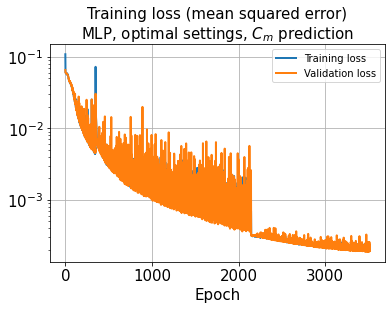

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

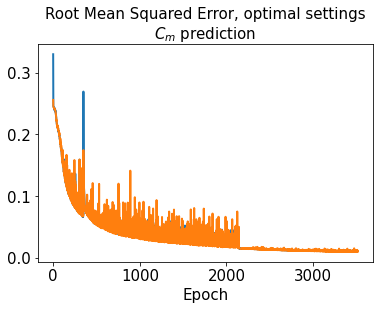

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

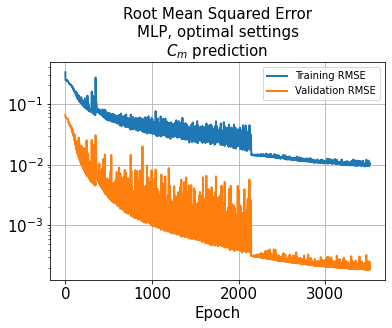

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

985/985 [==============================] - 3s 3ms/step - loss: 1.9123e-04 - rmse: 0.0094


In [38]:
val_results = model.evaluate(x_val, y_val)

282/282 [==============================] - 1s 3ms/step - loss: 1.9122e-04 - rmse: 0.0094


In [39]:
test_results = model.evaluate(x_test, y_test)

141/141 [==============================] - 0s 3ms/step - loss: 1.9538e-04 - rmse: 0.0096


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

141/141 [==============================] - 0s 1ms/step


In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.021519480444531416
0.8015405968385731


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.021531268226583022
0.8183642043195739


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.02198317136117153
0.8160629391468486


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_9beta_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

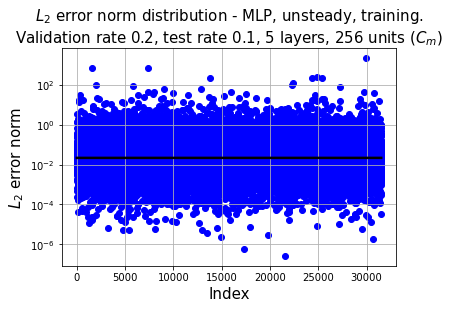

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

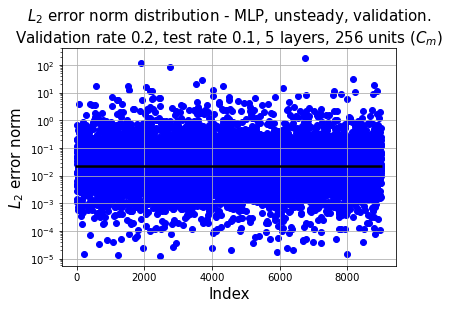

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

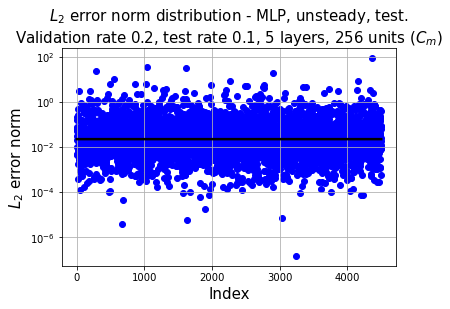

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

1407/1407 [==============================] - 2s 1ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(31500,)

In [67]:
max(predicted)

array([1.012041], dtype=float32)

In [68]:
l2_error(denormalize(predicted), denormalize(y))

0.0295944124652414

In [69]:
l2_error(predicted, y)

0.02156880922547319

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x[:,0] *= 5
x[:,0] += 10

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0182


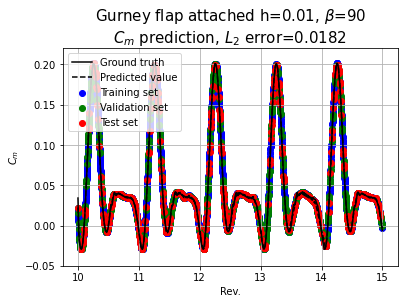

L2 error of Cm: 0.0171


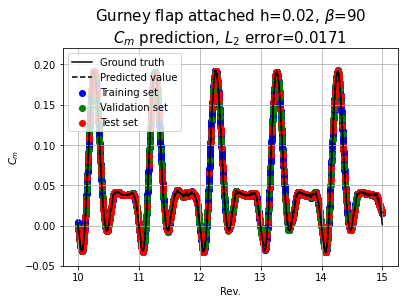

L2 error of Cm: 0.0184


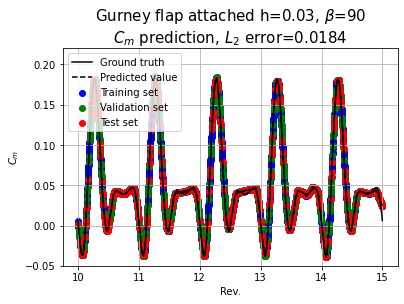

L2 error of Cm: 0.0159


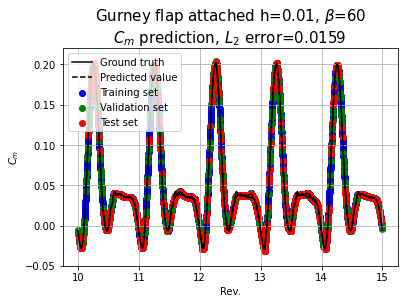

L2 error of Cm: 0.0285


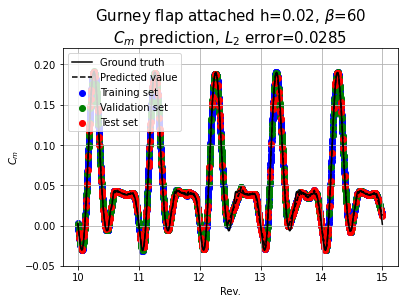

L2 error of Cm: 0.0343


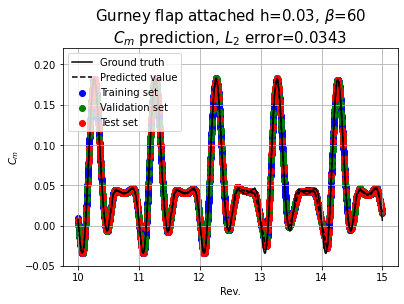

L2 error of Cm: 0.0138


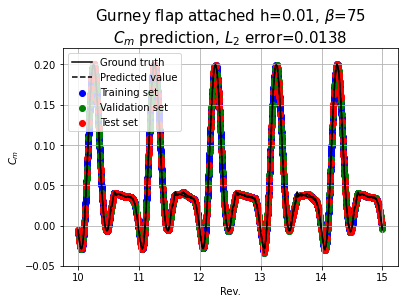

L2 error of Cm: 0.0178


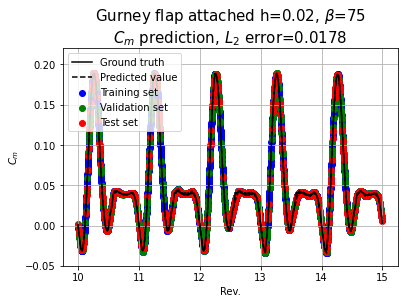

L2 error of Cm: 0.0231


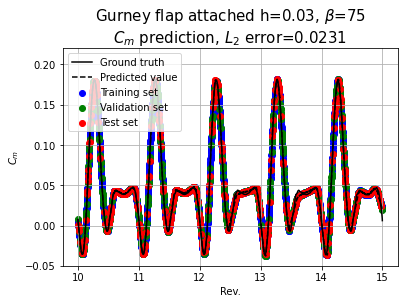

L2 error of Cm: nan


C:\Users\cfdML\AppData\Local\Temp\ipykernel_18204\3589810293.py:17: RuntimeWarning: invalid value encountered in double_scalars
  l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))


IndexError: list index out of range

In [77]:
h = [0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0,12):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [80]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0182


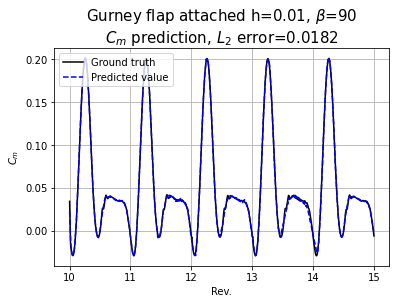

L2 error of Cm: 0.0171


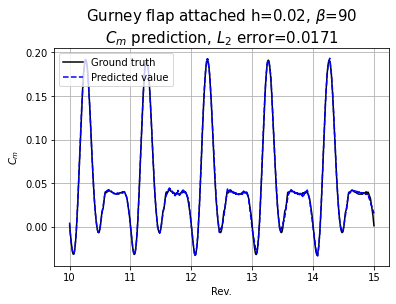

L2 error of Cm: 0.0184


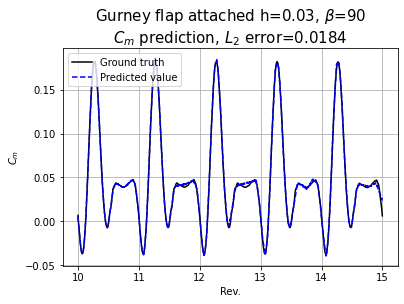

L2 error of Cm: 0.0159


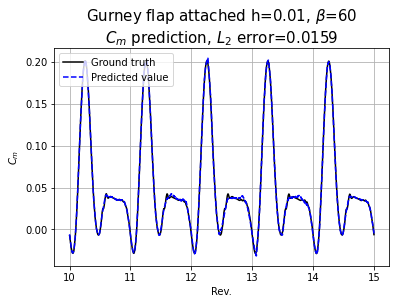

L2 error of Cm: 0.0285


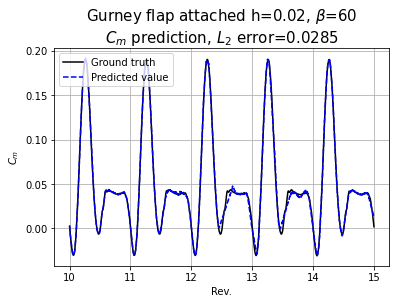

L2 error of Cm: 0.0343


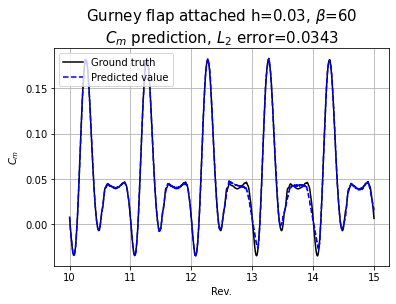

L2 error of Cm: 0.0138


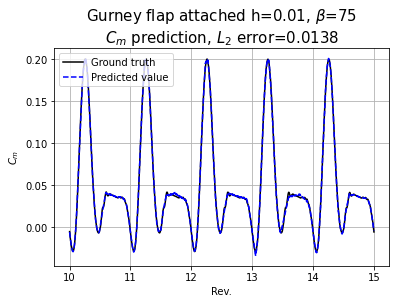

L2 error of Cm: 0.0178


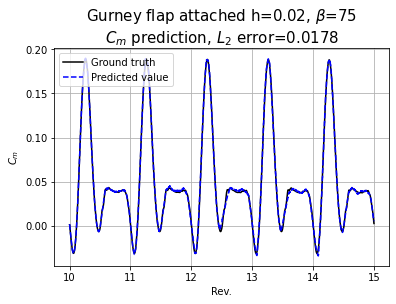

L2 error of Cm: 0.0231


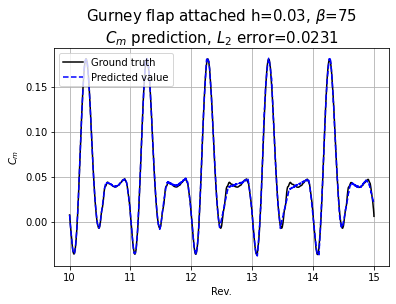

In [81]:
for i in range(0,9):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0182


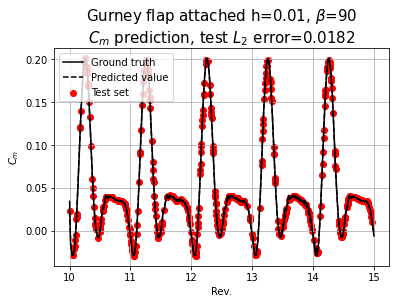

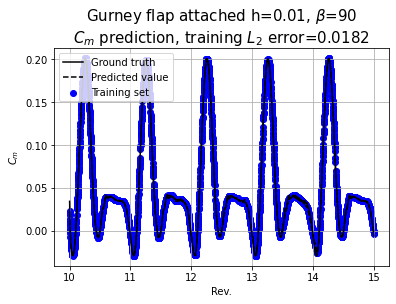

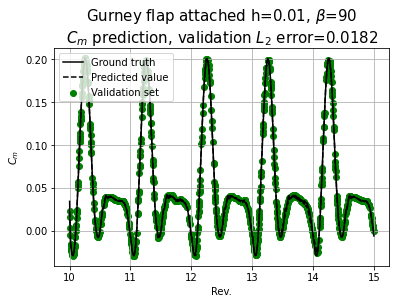

L2 error of Cm: 0.0171


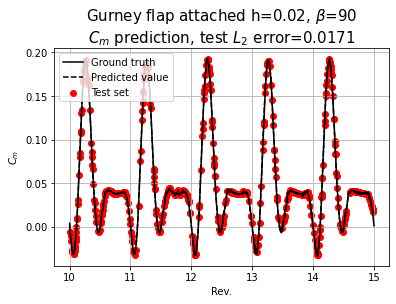

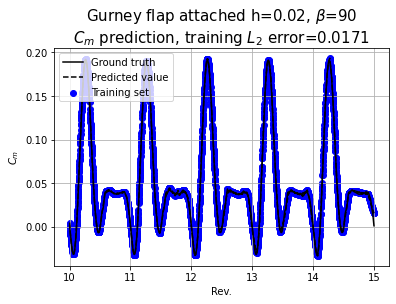

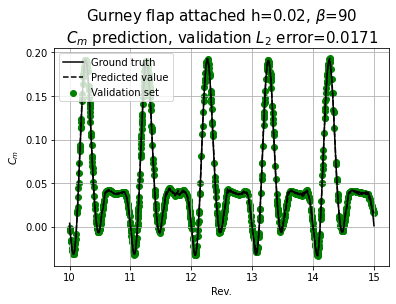

L2 error of Cm: 0.0184


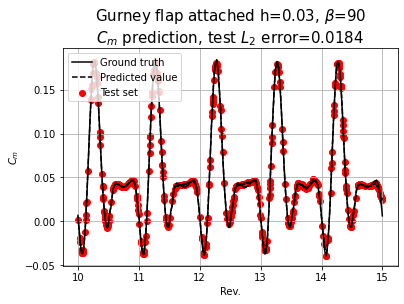

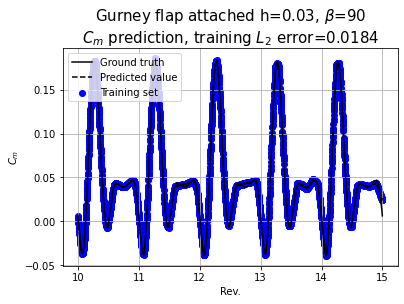

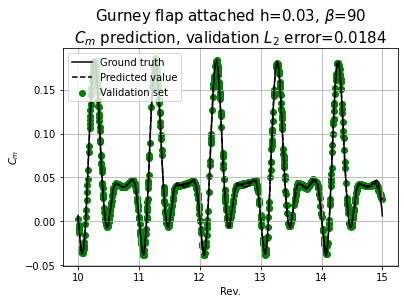

L2 error of Cm: 0.0159


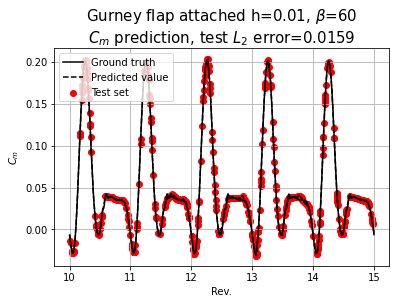

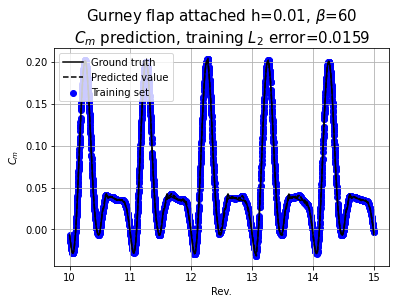

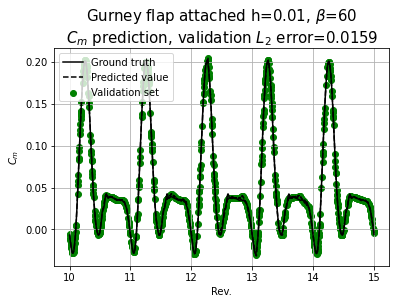

L2 error of Cm: 0.0285


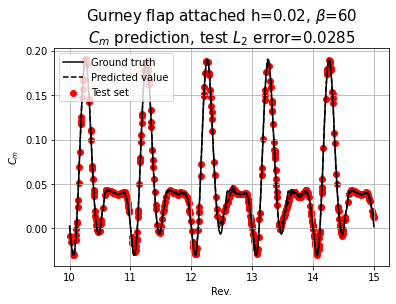

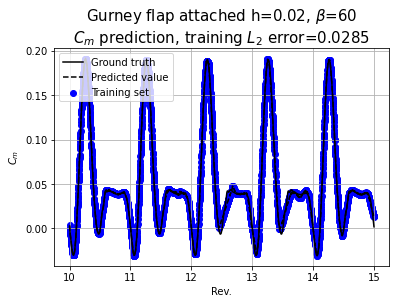

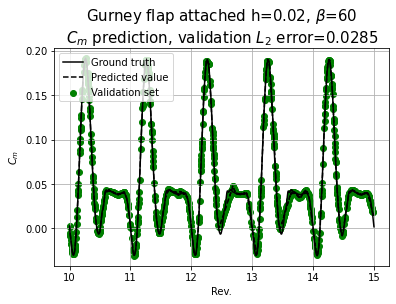

L2 error of Cm: 0.0343


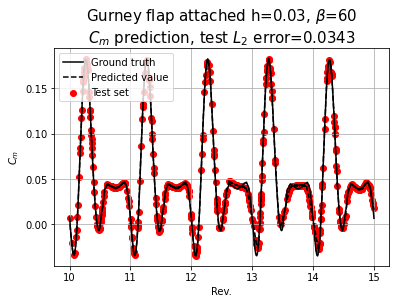

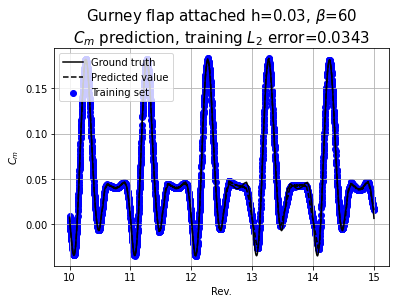

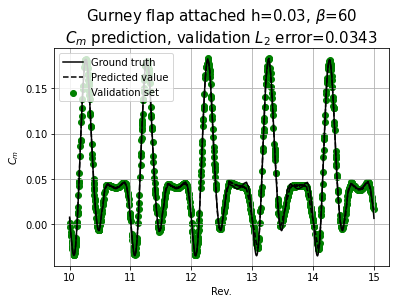

L2 error of Cm: 0.0138


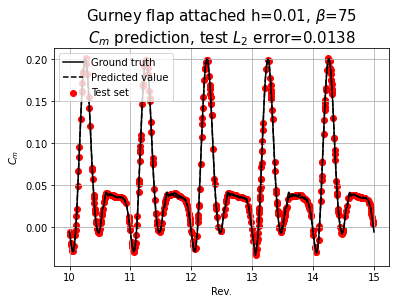

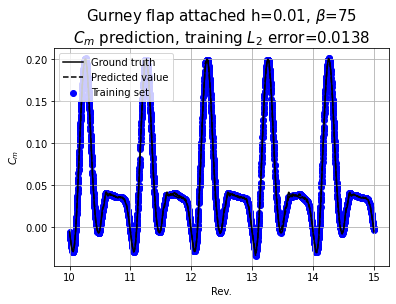

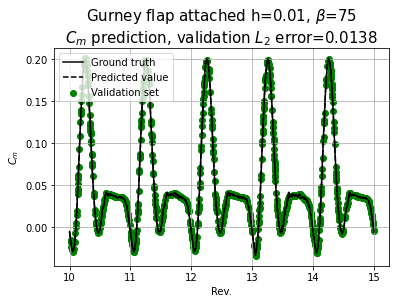

L2 error of Cm: 0.0178


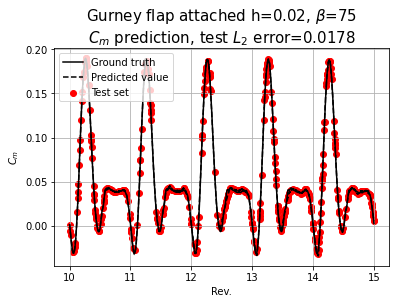

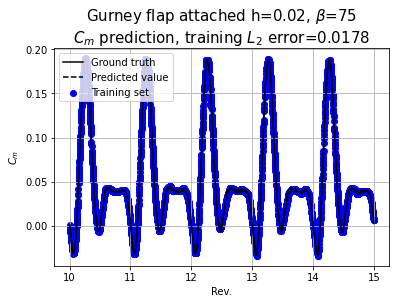

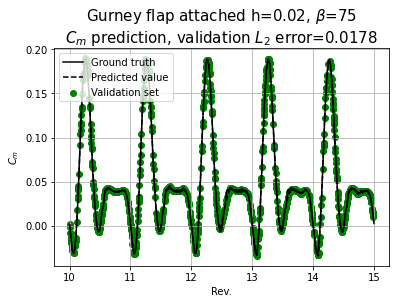

L2 error of Cm: 0.0231


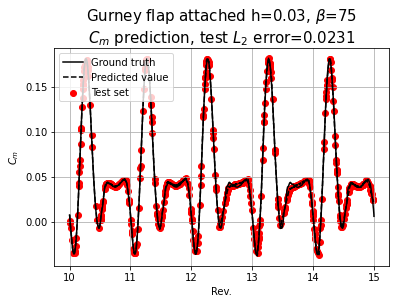

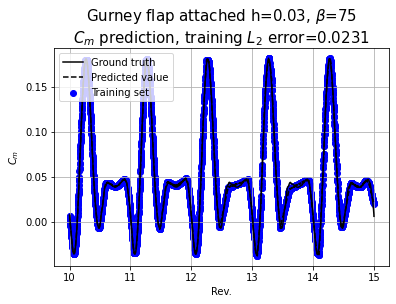

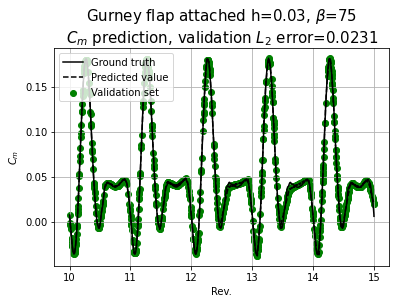

In [79]:
for i in range(0,9):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    title_train = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_Cm)
    title_val = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_Cm)
    title_test = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_Cm)
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"training.jpg"
    savename2 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"validation.jpg"
    savename3 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"test.jpg"
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_test, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename3, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_train, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_val, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()